<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E5%AD%A3%E7%AF%80%E5%A4%89%E5%8B%95%E3%81%AE%E3%81%82%E3%82%8B%E6%99%82%E7%B3%BB%E5%88%97%E3%81%8B%E3%82%89%E3%81%AE%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

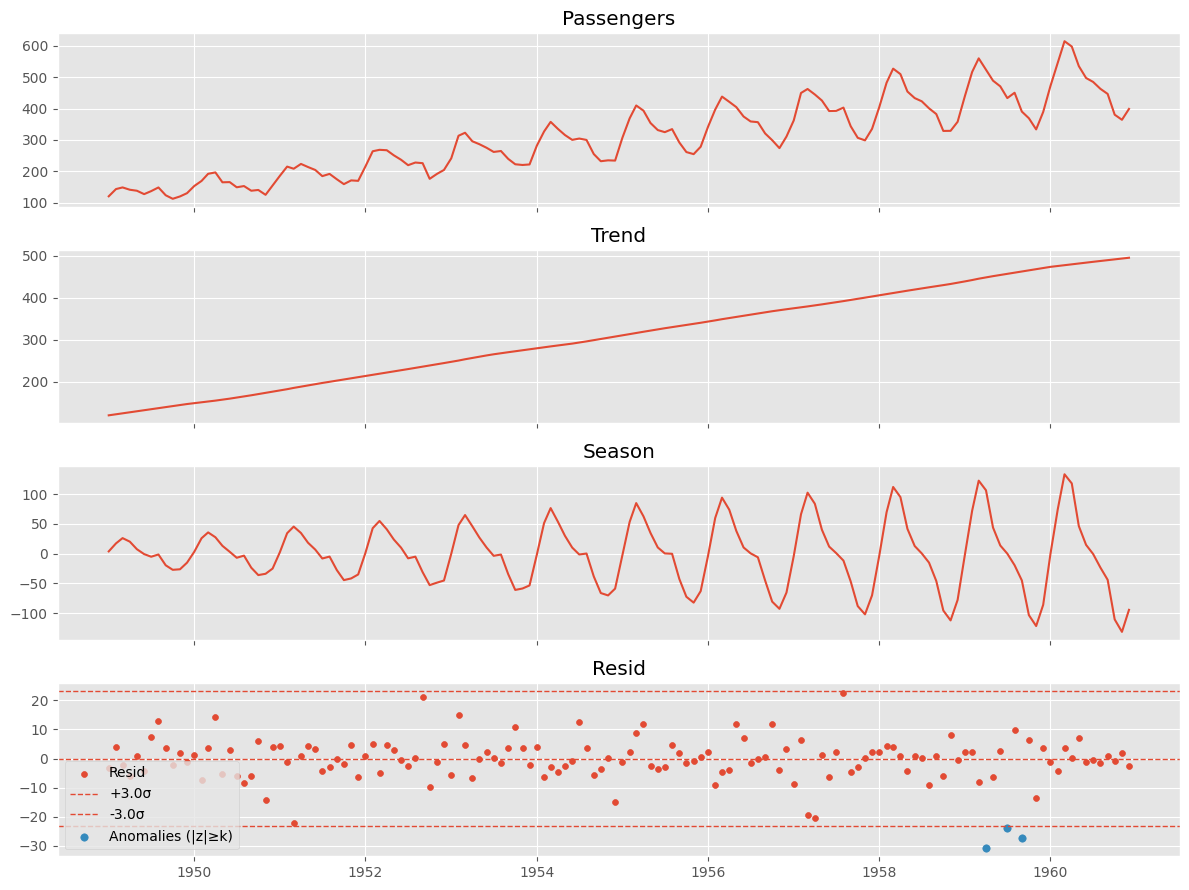

Residual anomalies detected: 3 / 144 (k=3.0)
Saved: passengers_series.csv, trend.csv, seasonal.csv, residual.csv


In [2]:
# Colab-ready: STL decomposition demo like the screenshot + anomaly markers on residuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If statsmodels is missing in your Colab, uncomment:
# !pip -q install statsmodels
from statsmodels.tsa.seasonal import STL

# ===== Settings =====
USE_REAL_AIRPASSENGERS = False  # True にすると実データを取得（ネット接続が必要）
K = 3.0                         # residual z-score threshold (|z| >= K)
plt.style.use("ggplot")         # 画像の雰囲気を近づける

# ===== 0) Load data =====
if USE_REAL_AIRPASSENGERS:
    # Real dataset (AirPassengers). Requires internet access in Colab.
    import pandas as pd
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url, parse_dates=["Month"])
    s = pd.Series(df["Passengers"].values,
                  index=pd.DatetimeIndex(df["Month"], freq="MS"),
                  name="Passengers")
    period = 12  # monthly seasonality
else:
    # Synthetic data that looks like AirPassengers (trend + multiplicative-like seasonality)
    n_years = 12
    period = 12
    N = n_years * period
    t = pd.date_range("1949-01-01", periods=N, freq="MS")

    rng = np.random.default_rng(7)
    trend = np.linspace(120, 500, N)                          # increasing trend
    # seasonal pattern (amplitude grows gradually to mimic multiplicative effect)
    month = np.arange(N) % period
    base_season = (np.sin(2*np.pi*month/period) +
                   0.4*np.sin(4*np.pi*month/period))
    amp = np.linspace(20, 110, N)                             # growing amplitude
    seasonal = amp * base_season
    noise = rng.normal(0, 10, N)

    y = trend + seasonal + noise
    s = pd.Series(y, index=t, name="Passengers")

# ===== 1) STL decomposition =====
stl = STL(s, period=period, robust=True)
res = stl.fit()
trend = res.trend
seasonal = res.seasonal
resid = res.resid

# Residual anomaly (z-score) for demo
sigma = resid.std(ddof=0)
z = resid / sigma
anomaly_mask = z.abs() >= K

# ===== 2) Plots (Passengers / Trend / Season / Resid) =====
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axes[0].plot(s.index, s.values)
axes[0].set_title("Passengers")

axes[1].plot(trend.index, trend.values)
axes[1].set_title("Trend")

axes[2].plot(seasonal.index, seasonal.values)
axes[2].set_title("Season")

axes[3].scatter(resid.index, resid.values, s=18, label="Resid")
axes[3].axhline(0, linestyle="--", linewidth=1)
axes[3].axhline( K*sigma, linestyle="--", linewidth=1, label=f"+{K}σ")
axes[3].axhline(-K*sigma, linestyle="--", linewidth=1, label=f"-{K}σ")
# highlight anomalies on residuals
axes[3].scatter(resid.index[anomaly_mask], resid.values[anomaly_mask],
                s=28, label="Anomalies (|z|≥k)")
axes[3].set_title("Resid")
axes[3].legend(loc="best")

plt.tight_layout()
plt.show()

# ===== 3) (Optional) Save CSVs =====
pd.DataFrame({"Passengers": s}).to_csv("passengers_series.csv")
trend.rename("trend").to_csv("trend.csv")
seasonal.rename("seasonal").to_csv("seasonal.csv")
resid.rename("residual").to_csv("residual.csv")
print(f"Residual anomalies detected: {anomaly_mask.sum()} / {len(s)} (k={K})")
print("Saved: passengers_series.csv, trend.csv, seasonal.csv, residual.csv")
